In [0]:
# Imports
import math
import random

import numpy as np
import matplotlib.pyplot as plt 


from sklearn.svm import SVC  
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [0]:
# Noise Logic
# Below are helper functions to add noise to the original data
# 3 type of noise generation logic are defined below:
# i>   Noisy cell data
# ii>  Noisy features 
# iii> Noisy row data

def addRandomNoiseToCells(a, b, noisyCellsWeight):
  rows = a.shape[0]
  cols = a.shape[1] + 1
  Z = np.zeros((rows,cols))
  Z[:,:-1] = a
  Z[:, cols - 1] = b
  
  totalCells = rows*cols
  cellIndices = np.array(range(0,totalCells))
  np.random.shuffle(Z)
  random.shuffle(cellIndices)
   
  noisyCells = totalCells * noisyCellsWeight/100
  
  for i in range(int(math.floor(noisyCells))):
    Z[int(cellIndices[i-1]/cols),cellIndices[i-1]%cols] = random.randint(-999,999)
  
  a = Z[:, :-1]
  b = Z[:, a.shape[1]]
  
  return a, b
 

def addVariableNoiseToCells(a, b, minNoise, maxNosie, noisyCellsWeight):
  rows = a.shape[0]
  cols = a.shape[1] + 1
  Z = np.zeros((rows,cols))
  Z[:,:-1] = a
  Z[:, cols - 1] = b
  
  totalCells = rows*(cols-1)
  cellIndices = np.array(range(0,totalCells))
  np.random.shuffle(Z)
  random.shuffle(cellIndices)
   
  noisyCells = totalCells * noisyCellsWeight/100
  
  for i in range(int(math.floor(noisyCells))):
    if random.randint(0,1) == 0:
      Z[int(cellIndices[i-1]/(cols-1)),cellIndices[i-1]%(cols-1)] = Z[int(cellIndices[i-1]/(cols-1)),cellIndices[i-1]%(cols-1)] * (100 + random.randint(minNoise*100,maxNosie*100)/100) / 100
    else:
      Z[int(cellIndices[i-1]/(cols-1)),cellIndices[i-1]%(cols-1)] = Z[int(cellIndices[i-1]/(cols-1)),cellIndices[i-1]%(cols-1)] * (100 - random.randint(minNoise*100,maxNosie*100)/100) / 100
 
  a = Z[:, :-1]
  b = Z[:, a.shape[1]]
  return a, b


def addIrrelevantFeatureNoise(a, b, numberOfIrrelevantFeatures):
  rows = a.shape[0]
  originalFeatures = a.shape[1]
  cols = originalFeatures + 1 + numberOfIrrelevantFeatures
  Z = np.zeros((rows,cols))
  Z[:,:-(numberOfIrrelevantFeatures + 1)] = a
  Z[:, cols - 1] = b
   
  np.random.shuffle(Z) 
  
  for i in range(rows):
    for j in range(numberOfIrrelevantFeatures):
      Z[i,originalFeatures + j] = random.randint(-999,999)
  
  a = Z[:, :-1]
  b = Z[:, a.shape[1]]
  
  return a, b


def addVariableNoiseToRows(a, b, minNoise, maxNosie, noisyRowsWeight):
  rows = a.shape[0]
  cols = a.shape[1] + 1
  Z = np.zeros((rows,cols))
  Z[:,:-1] = a
  Z[:, cols - 1] = b
  
  rowIndices = np.array(range(0,rows))
  
  np.random.shuffle(Z)
  random.shuffle(rowIndices)
  noisyRows = rows * noisyRowsWeight/100
  
  for i in range(int(math.floor(noisyRows))):
    for j in range(cols-1):
      if random.randint(0,1) == 0:
        Z[rowIndices[i-1],j] = Z[rowIndices[i-1],j] * (100 + random.randint(minNoise*100,maxNosie*100)/100) / 100
      else:
        Z[rowIndices[i-1],j] = Z[rowIndices[i-1],j] * (100 - random.randint(minNoise*100,maxNosie*100)/100) / 100
 
  a = Z[:, :-1]
  b = Z[:, a.shape[1]]
  return a, b


In [0]:
def getOriginalData():
  # Original Data
  # Breast Cancer Dataset 
  # 569 data points with 30 features 
  cancer = load_breast_cancer()
  # print(cancer['DESCR'])
  X = cancer['data']
  y = cancer['target']
  
  return X, y

In [0]:
def preprocessData(X, y):
  # 70/30 split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  # Feature Scaling
  # StandardScaler() will normalize the features (each column of X) 
  # so that each column/feature/variable will have mean = 0 and standard deviation = 1
  scaler = StandardScaler()
  # Fit only to the training data
  scaler.fit(X_train)

  # StandardScaler(copy=True, with_mean=True, with_std=True)

  # Now apply the transformations to the data:
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

In [0]:
# ML algorithms
def getMLPResults(X_train, X_test, y_train, y_test):
  mlp = MLPClassifier(hidden_layer_sizes=(X_train.shape[1],X_train.shape[1],X_train.shape[1]))
  mlp.fit(X_train,y_train)

  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(X_train.shape[1],X_train.shape[1],X_train.shape[1]), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nesterovs_momentum=True, power_t=0.5, random_state=None,
         shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
         verbose=False, warm_start=False)
  predictions = mlp.predict(X_test)
  return mlp.score(X_test, y_test)

def getSVMResults(X_train, X_test, y_train, y_test):
  svclassifier = SVC(kernel='linear')  
  svclassifier.fit(X_train, y_train)  
  y_pred = svclassifier.predict(X_test)  
  return svclassifier.score(X_test, y_test)

def getLogisticsResults(X_train, X_test, y_train, y_test):
  logreg = LogisticRegression(solver='lbfgs')
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)  
  return logreg.score(X_test, y_test)

#   print(confusion_matrix(y_test,predictions))
#   print(classification_report(y_test,predictions)) 

In [0]:
# Plotting helper functions

def plot2DGraph(X,Y1,Y2,Y3,title, xLabel):
  plt.rc("font", size=14)
  plt.figure()
  plt.plot(X, Y1, "r", label='MLP')
  plt.plot(X, Y2, "g", label='SVM')
  plt.plot(X, Y3,  'b', label='logistic')
  plt.xlabel(xLabel)
  plt.ylabel('Accuracy')
  plt.legend(loc="upper right")
  plt.title(title)
  plt.savefig(title)
  plt.show()
  
def plotSimple2DGraph(X,Y, title, label, lineColor):
  plt.figure()
  plt.plot(X, Y, lineColor, label=label)
  plt.xlabel('% of noisy cells')
  plt.ylabel('Accuracy')
  plt.legend(loc="upper right")
  plt.title(title)
  plt.savefig(title)
  plt.show()
  
def plotConsolidated2DGraph(X,Y1,Y2,Y3, title, xLabel):
  plt.figure()
  plt.plot(X, Y1, 'r', label='MLP')
  plt.plot(X, Y2, 'g', label='SVM')
  plt.plot(X, Y3, 'b', label='Logistics')
  plt.xlabel(xLabel)
  plt.ylabel('Accuracy')
  plt.legend(loc="best")
  plt.title(title)
  plt.savefig(title)
  plt.show()


In [0]:
# Noise Description:
# Add variable noise(+/- error) to random rows
# Affected Row Count = 0% -> 20% of all rows
def runExperimentsForVariableRowNoise():
  experiments = 10
  noisyCellsWeight = 35
  variableNoiseValue = 20

  accuracyNN = np.zeros((variableNoiseValue, noisyCellsWeight))
  accuracySVM = np.zeros((variableNoiseValue, noisyCellsWeight))
  accuracyLogistics = np.zeros((variableNoiseValue, noisyCellsWeight))

  for exp in range(experiments):
    for noiseValue in range(0, variableNoiseValue, 5):
      for noisyCells in range(noisyCellsWeight):
        X, y = getOriginalData()
        X, y = addVariableNoiseToRows(X,y,noiseValue,noiseValue+5, noisyCells)
        X_train, X_test, y_train, y_test = preprocessData(X, y)
        accuracyNN[noiseValue,noisyCells] += (getMLPResults(X_train, X_test, y_train, y_test))
        accuracySVM[noiseValue,noisyCells] += (getSVMResults(X_train, X_test, y_train, y_test))
        accuracyLogistics[noiseValue,noisyCells] += (getLogisticsResults(X_train, X_test, y_train, y_test))
        
  accuracyNN /= experiments
  accuracySVM /= experiments
  accuracyLogistics /= experiments
  return noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics

# Noise Description:
# Add random noise(outlier) to random cells
# Affected Cells Count = 0% -> 30%
def runExperimentsForOutliersToRandomCells():
  experiments = 10
  noisyCellsWeight = 20
  noise = np.zeros(noisyCellsWeight)
  accuracyNN = np.zeros(noisyCellsWeight)
  accuracySVM = np.zeros(noisyCellsWeight)
  accuracyLogistics = np.zeros(noisyCellsWeight)
  for exp in range(experiments):
    for i in range(noisyCellsWeight):
      X, y = getOriginalData()
      X, y = addRandomNoiseToCells(X,y,i)
      X_train, X_test, y_train, y_test = preprocessData(X, y)
      noise[i] += i
      accuracyNN[i] += (getMLPResults(X_train, X_test, y_train, y_test))
      accuracySVM[i] += (getSVMResults(X_train, X_test, y_train, y_test))
      accuracyLogistics[i] += (getLogisticsResults(X_train, X_test, y_train, y_test))

  noise /= experiments
  accuracyNN /= experiments
  accuracySVM /= experiments
  accuracyLogistics /= experiments
  return noise,accuracyNN, accuracySVM, accuracyLogistics

# Noise Description:
# Irrelevant features added with random values
# Number of irrelevant features = 1 -> 30
def runExperimentsForIrrelevantFeatures():
  experiments = 10
  noisyFeatures = 30 
  accuracyNN = np.zeros(noisyFeatures)
  accuracySVM = np.zeros(noisyFeatures)
  accuracyLogistics = np.zeros(noisyFeatures)
  for exp in range(experiments):
    for i in range(noisyFeatures):
      X, y = getOriginalData()
      X, y = addIrrelevantFeatureNoise(X,y,i)
      X_train, X_test, y_train, y_test = preprocessData(X, y)
      accuracyNN[i] += (getMLPResults(X_train, X_test, y_train, y_test))
      accuracySVM[i] += (getSVMResults(X_train, X_test, y_train, y_test))
      accuracyLogistics[i] += (getLogisticsResults(X_train, X_test, y_train, y_test))
 
  accuracyNN /= experiments
  accuracySVM /= experiments
  accuracyLogistics /= experiments
  return noisyFeatures,accuracyNN, accuracySVM, accuracyLogistics

# Noise Description:
# Add variable noise(+/- error) to random cells
# Affected Cells Count = 0% -> 20%
def runExperimentsForVariableNoiseToRandomCells():
  experiments = 10
  noisyCellsWeight = 35
  variableNoiseValue = 20

  accuracyNN = np.zeros((variableNoiseValue, noisyCellsWeight))
  accuracySVM = np.zeros((variableNoiseValue, noisyCellsWeight))
  accuracyLogistics = np.zeros((variableNoiseValue, noisyCellsWeight))

  for exp in range(experiments):
    for noiseValue in range(0, variableNoiseValue, 5):
      for noisyCells in range(noisyCellsWeight):
        X, y = getOriginalData()
        X, y = addVariableNoiseToCells(X,y,noiseValue,noiseValue+5, noisyCells)
        X_train, X_test, y_train, y_test = preprocessData(X, y)
        accuracyNN[noiseValue,noisyCells] += (getMLPResults(X_train, X_test, y_train, y_test))
        accuracySVM[noiseValue,noisyCells] += (getSVMResults(X_train, X_test, y_train, y_test))
        accuracyLogistics[noiseValue,noisyCells] += (getLogisticsResults(X_train, X_test, y_train, y_test))
        
  accuracyNN /= experiments
  accuracySVM /= experiments
  accuracyLogistics /= experiments
  return noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics

In [0]:
def plotResultsForExperimentsOnOutliersToRandomCells(noise,accuracyNN, accuracySVM, accuracyLogistics):
  plot2DGraph(noise,accuracyNN, accuracySVM, accuracyLogistics, "Effect of random 'Cell' noise", "% of noisy cells")

  
def plotResultsOfExperimentOnVariableRowNoise(noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics):
  X = range(0, noisyCellsWeight)
  for noiseValue in range(0, variableNoiseValue, 5):
    minNoise = noiseValue
    maxNoise = noiseValue + 5
    title = "Effect of variable row noise\n" + "Noise Range = [" + str(minNoise) + "," + str(maxNoise) + "]%"
    plotConsolidated2DGraph(X,accuracyNN[noiseValue],accuracySVM[noiseValue],accuracyLogistics[noiseValue], title, "% of noisy rows")
    
    
def plotResultsForExperimentsOnIrrelevantFeatures(noisyFeatures,accuracyNN, accuracySVM, accuracyLogistics):
  plot2DGraph(noisyFeatures,accuracyNN, accuracySVM, accuracyLogistics, "Effect of irrelevant feature on accuracy", "Number of irrelevant features")


def plotResultsOfExperimentsOnVariableNoiseToRandomCells(noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics):
  X = range(0, noisyCellsWeight)
  for noiseValue in range(0, variableNoiseValue, 5):
    minNoise = noiseValue
    maxNoise = noiseValue + 5
    title = "Effect of variable cell noise\n" + "Noise Range = [" + str(minNoise) + "," + str(maxNoise) + "]%"
    plotConsolidated2DGraph(X,accuracyNN[noiseValue],accuracySVM[noiseValue],accuracyLogistics[noiseValue], title, "% of noisy cells")

In [0]:
# Run Experiments to study effect of Outliers on random cells
noise,accuracyNN, accuracySVM, accuracyLogistics = runExperimentsForOutliersToRandomCells()

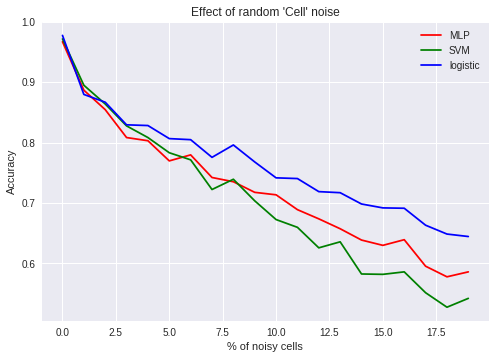

In [10]:
#Plot results
plotResultsForExperimentsOnOutliersToRandomCells(noise,accuracyNN, accuracySVM, accuracyLogistics)

In [0]:
# Run Experiments to study effect of gaussian noise on random cells
noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics = runExperimentsForVariableNoiseToRandomCells()


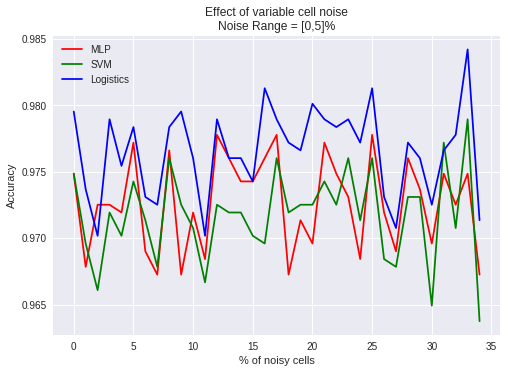

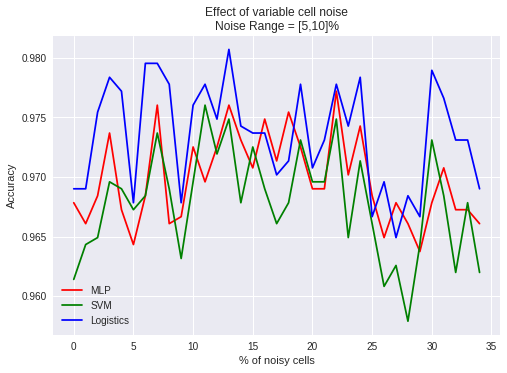

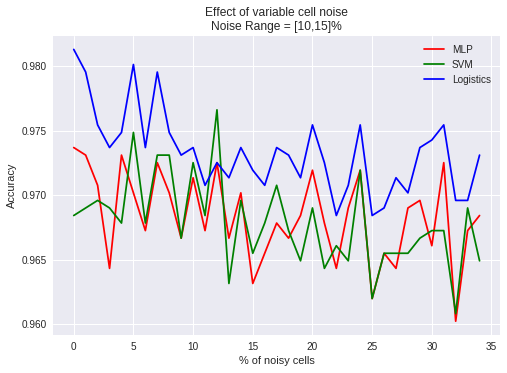

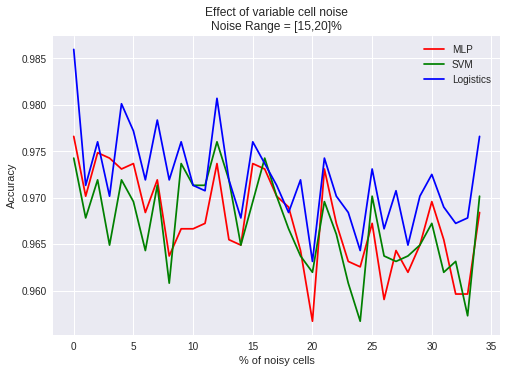

In [12]:
#Plot results
plotResultsOfExperimentsOnVariableNoiseToRandomCells(noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics)

In [0]:
# Run Experiments to study effect of irrelevant features
noisyFeatures,accuracyNN, accuracySVM, accuracyLogistics = runExperimentsForIrrelevantFeatures()

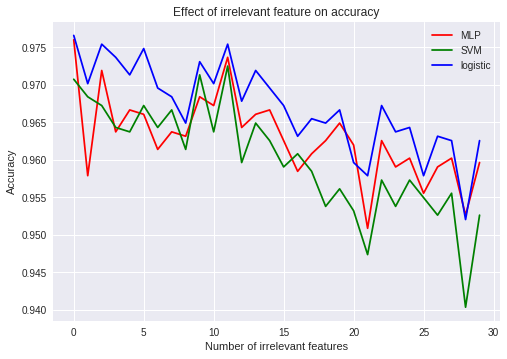

In [14]:
#Plot results
plotResultsForExperimentsOnIrrelevantFeatures(range(noisyFeatures),accuracyNN, accuracySVM, accuracyLogistics)

In [0]:
# Run Experiments to study effect of gaussian noise on entire row values
noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics = runExperimentsForVariableRowNoise()

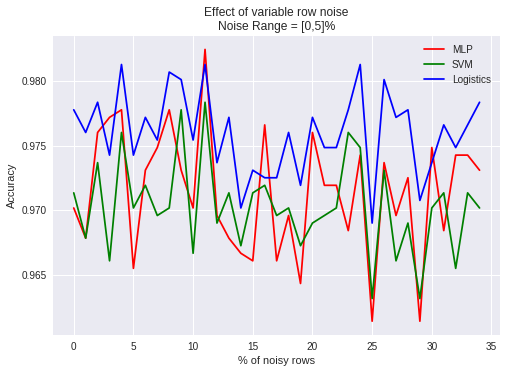

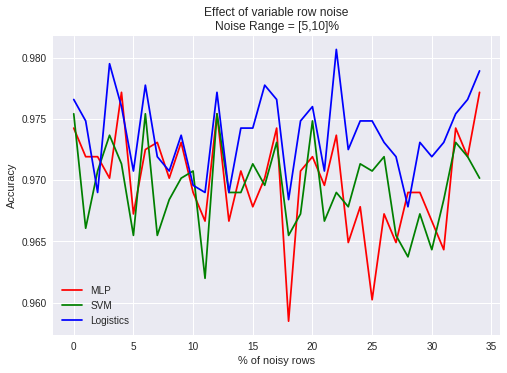

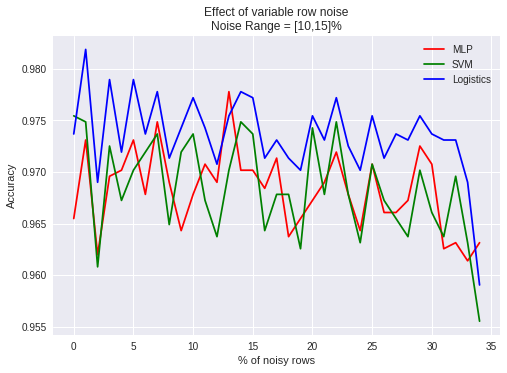

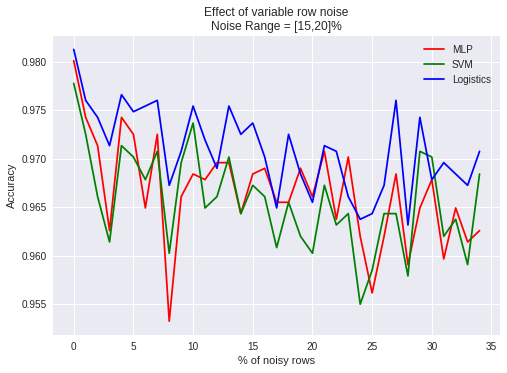

In [16]:
#Plot results
plotResultsOfExperimentOnVariableRowNoise(noisyCellsWeight, variableNoiseValue, accuracyNN, accuracySVM, accuracyLogistics)

In [0]:
# 3D Plotting

# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = Axes3D(fig)
 
# # put 0s on the y-axis, and put the y axis on the z-axis
# # ax.plot(xs=x, ys= y, zs=z)
# # ax.scatter(x,y,z, depthshade=True)
# # ax.contour(x,y,z)
# def f(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

# X = [0,1,2,3,4,5]
# Y = [0,1,2,3,4,5]
# Z = [0,1,2,3,4,5]

# x = np.linspace(-6, 6, 30)
# y = np.linspace(-6, 6, 30)

# X, Y = np.meshgrid(x, y)
# Z = f(X, Y)


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot_wireframe(X, Y, Z, color='black')
# ax.set_title('wireframe');

# # ax.view_init(90, -90)
# plt.show()
 